In [2]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.signal import butter, sosfilt, find_peaks
from io import BytesIO
import base64
from typing import Union

In [3]:
def normalize_audio(audio):
    """Normalize audio signal to [-1, 1]."""
    return audio / np.max(np.abs(audio))

In [4]:
def bandpass_filter(data, lowcut, highcut, sample_rate, order=2):
    """Apply a bandpass filter using second-order sections for stability."""
    nyquist = 0.5 * sample_rate
    low = lowcut / nyquist
    high = highcut / nyquist
    sos = butter(order, [low, high], btype='band', output='sos')
    y = sosfilt(sos, data)
    return y

In [5]:
def plot_audio_signals(filtered, sample_rate):
    """Plot filtered audio signal."""
    times = np.linspace(0, len(filtered) / sample_rate, num=len(filtered))

    plt.figure(figsize=(18, 9))
    plt.plot(times, filtered)
    plt.title('Filtered Audio')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.tight_layout()
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close()
    buf.seek(0)
    return buf

In [6]:
def plot_r_r_signals(times, filtered_audio, peaks):
    """Plot R-R intervals."""
    plt.figure(figsize=(10, 4))
    plt.plot(times, filtered_audio, label='Filtered signal')
    plt.plot(times[peaks], filtered_audio[peaks], 'x', label='Detected peaks')
    plt.title('Detected R-peaks in the signal')
    plt.legend()
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')

    plt.show()

In [7]:
def get_audio_details(r_peak_times):
    """Calculate audio details."""
    rr_intervals = np.diff(r_peak_times)
    bpm = 60 / np.mean(rr_intervals)
    ibi = np.mean(rr_intervals)
    sdnn = np.std(rr_intervals)
    sdsd = np.std(np.diff(rr_intervals))
    rmssd = np.sqrt(np.mean(np.diff(rr_intervals)**2))
    nn20 = np.sum(np.abs(np.diff(rr_intervals)) > 0.02)
    pnn20 = nn20 / len(rr_intervals) * 100
    nn50 = np.sum(np.abs(np.diff(rr_intervals)) > 0.05)
    pnn50 = nn50 / len(rr_intervals) * 100
    hr_mad = np.median(np.abs(rr_intervals - np.median(rr_intervals)))
    sd1 = np.sqrt(np.std(rr_intervals - np.mean(rr_intervals))**2 * 0.5)
    sd2 = np.sqrt(2 * np.std(rr_intervals)**2 - sd1**2)
    s = np.pi * sd1 * sd2
    sd1_sd2_ratio = sd1 / sd2
    breathing_rate = 60 / (3 * np.median(rr_intervals))
    
    data = {
        "BPM": round(bpm, 2),
        "IBI": round(ibi, 2),
        "SDNN": round(sdnn, 2),
        "SDSD": round(sdsd, 2),
        "RMSSD": round(rmssd, 2),
        "pNN20": round(pnn20, 2),
        "pNN50": round(pnn50, 2),
        "HR_MAD": round(hr_mad, 2),
        "SD1": round(sd1, 2),
        "SD2": round(sd2, 2),
        "S": round(s, 2),
        "SD1_SD2_Ratio": round(sd1_sd2_ratio, 2),
        "Breathing Rate": round(breathing_rate, 2)
    }
    return data

In [8]:
def handle_base64_audio(file: Union[str, BytesIO]):
    """Decode base64 string and load audio."""
    if isinstance(file, str):
        try:
            audio, sample_rate = sf.read(file)
        except (FileNotFoundError, RuntimeError):
            # If not a path, treat it as a base64-encoded string
            file = BytesIO(base64.b64decode(file))
            audio, sample_rate = sf.read(file)
    # audio_data = base64_string
    audio, sample_rate = sf.read(file)
    if audio.ndim > 1:
        audio = audio[:, 0]
    return audio, sample_rate

In [9]:
def process_audio(base64_string: Union[str, BytesIO]):
    """Process the audio data."""
    audio, sample_rate = handle_base64_audio(base64_string)
    # normalized_audio = normalize_audio(audio)
    filtered_audio = bandpass_filter(audio, 20, 150, sample_rate)
    return filtered_audio, sample_rate

In [10]:
def create_plot_img(base64_string):
    """Create a plot image of the filtered audio."""
    filtered_audio, sample_rate = process_audio(base64_string)
    plot_buffer = plot_audio_signals(filtered_audio, sample_rate)
    return plot_buffer

In [11]:
def create_rr_plot_img(base64_string: Union[str, BytesIO]):
    """Create a plot image of R-R intervals."""
    filtered_audio, sample_rate = process_audio(base64_string)
    print(sample_rate)
    times = np.arange(filtered_audio.size) / sample_rate
    peaks, _ = find_peaks(filtered_audio, height=np.mean(filtered_audio), distance=sample_rate/4)
    rr_plot_buffer = plot_r_r_signals(times, filtered_audio, peaks)
    return rr_plot_buffer

In [12]:
def fetal_analysis(base64_string):
    """Perform detailed analysis on the audio."""
    filtered_audio, sample_rate = process_audio(base64_string)
    times = np.arange(filtered_audio.size) / sample_rate
    peaks, _ = find_peaks(filtered_audio, height=np.mean(filtered_audio), distance=sample_rate/4)
    r_peak_times = times[peaks]
    info = get_audio_details(r_peak_times)
    return info

In [13]:
filepath = "media/фетальник_больничный.wav"

48000


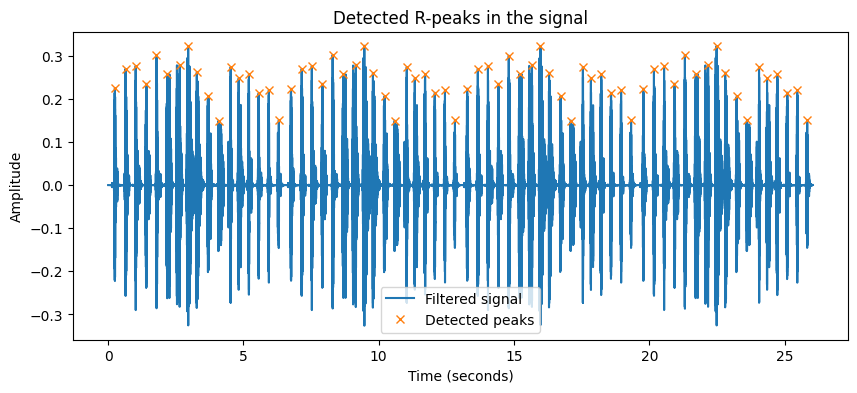

In [14]:
create_rr_plot_img(filepath)

In [15]:
filtered_audio, sample_rate = process_audio(filepath)
times = np.arange(filtered_audio.size) / sample_rate
peaks, _ = find_peaks(filtered_audio, height=np.mean(filtered_audio), distance=sample_rate/4)
r_peak_times = times[peaks]
r_peak_times

array([ 0.24960417,  0.6431875 ,  1.0175    ,  1.402625  ,  1.7866875 ,
        2.18583333,  2.64479167,  2.95820833,  3.27633333,  3.70735417,
        4.0810625 ,  4.52620833,  4.82247917,  5.20354167,  5.565375  ,
        5.93829167,  6.30739583,  6.75829167,  7.15185417,  7.52616667,
        7.91129167,  8.29535417,  8.6945    ,  9.15345833,  9.466875  ,
        9.785     , 10.21602083, 10.58972917, 11.034875  , 11.33114583,
       11.71220833, 12.07404167, 12.44695833, 12.8160625 , 13.2669375 ,
       13.66052083, 14.03483333, 14.41995833, 14.80404167, 15.20316667,
       15.662125  , 15.97554167, 16.29366667, 16.7246875 , 17.09839583,
       17.54354167, 17.8398125 , 18.220875  , 18.5826875 , 18.955625  ,
       19.32472917, 19.77560417, 20.1691875 , 20.5435    , 20.928625  ,
       21.3126875 , 21.71183333, 22.17079167, 22.48420833, 22.80233333,
       23.23335417, 23.6070625 , 24.05220833, 24.34847917, 24.72954167,
       25.091375  , 25.46429167, 25.83339583])

In [16]:
r_peak_times_clear = r_peak_times - r_peak_times[0]

In [17]:
f_time = r_peak_times[0]
last_time = r_peak_times[-1]
timing = last_time - f_time
timing

25.583791666666666

In [18]:
60 * len(r_peak_times) / timing

159.47597030020634

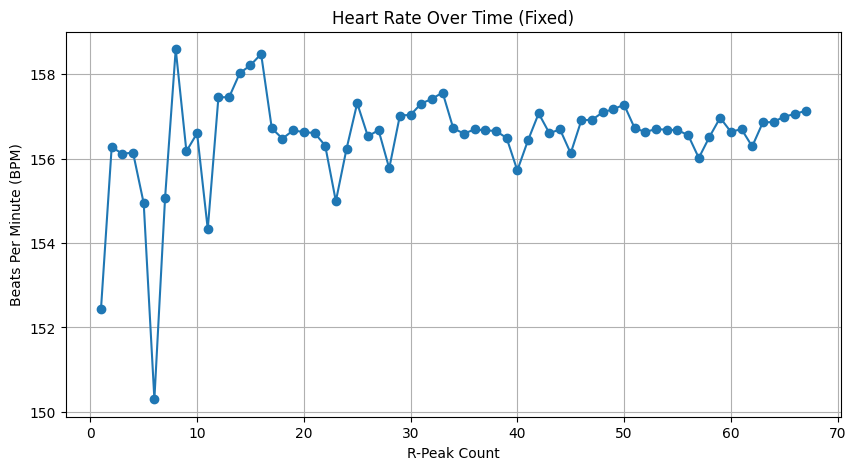

In [19]:
valid_r_peak_times = r_peak_times_clear[1:]

# Compute BPM values excluding the first invalid point
bpm_fixed = [60 * (i + 1) / valid_r_peak_times[i] for i in range(len(valid_r_peak_times))]

# Plotting the fixed BPM graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(bpm_fixed) + 1), bpm_fixed, marker='o')
plt.title("Heart Rate Over Time (Fixed)")
plt.xlabel("R-Peak Count")
plt.ylabel("Beats Per Minute (BPM)")
plt.grid()
plt.show()

In [21]:
np.max(bpm_fixed)

158.58703358273164

In [22]:
np.min(bpm_fixed)

150.3013855908984

In [ ]:
# BPM
np.mean(bpm_fixed)

156.52964926059133

In [ ]:
# Variability MS
rr_intervals = np.diff(valid_r_peak_times)

# Calculate SDNN (Standard Deviation of NN intervals)
sdnn = np.std(rr_intervals)

# Calculate RMSSD (Root Mean Square of Successive Differences)
rmssd = np.sqrt(np.mean(np.diff(rr_intervals) ** 2))

sdnn, rmssd

(0.04485373228747013, 0.0718457344730064)

In [ ]:
# Variability BPM
hr_values = 60 / rr_intervals

# Calculate SDNN in BPM
sdnn_bpm = np.std(hr_values)

# Calculate RMSSD in BPM
rmssd_bpm = np.sqrt(np.mean(np.diff(hr_values) ** 2))

sdnn_bpm, rmssd_bpm

(19.53234091874904, 30.772086497757268)

In [24]:
# Amplitude of HR variability
amplitude_bpm = np.max(bpm_fixed) - np.min(bpm_fixed)
amplitude_bpm

8.28564799183323

In [15]:
intervals = np.diff(r_peak_times)
intervals

array([0.39358333, 0.3743125 , 0.385125  , 0.3840625 , 0.39914583,
       0.45895833, 0.31341667, 0.318125  , 0.43102083, 0.37370833,
       0.44514583, 0.29627083, 0.3810625 , 0.36183333, 0.37291667,
       0.36910417, 0.45089583, 0.3935625 , 0.3743125 , 0.385125  ,
       0.3840625 , 0.39914583, 0.45895833, 0.31341667, 0.318125  ,
       0.43102083, 0.37370833, 0.44514583, 0.29627083, 0.3810625 ,
       0.36183333, 0.37291667, 0.36910417, 0.450875  , 0.39358333,
       0.3743125 , 0.385125  , 0.38408333, 0.399125  , 0.45895833,
       0.31341667, 0.318125  , 0.43102083, 0.37370833, 0.44514583,
       0.29627083, 0.3810625 , 0.3618125 , 0.3729375 , 0.36910417,
       0.450875  , 0.39358333, 0.3743125 , 0.385125  , 0.3840625 ,
       0.39914583, 0.45895833, 0.31341667, 0.318125  , 0.43102083,
       0.37370833, 0.44514583, 0.29627083, 0.3810625 , 0.36183333,
       0.37291667, 0.36910417])

In [17]:
heart_rates = 60 / intervals
heart_rates

array([152.44547957, 160.2938721 , 155.79357352, 156.22457282,
       150.32099796, 130.73082161, 191.43844722, 188.60510806,
       139.20440814, 160.55301594, 134.78728881, 202.51740384,
       157.45448581, 165.82220175, 160.89385475, 162.55573743,
       133.06842859, 152.45354931, 160.2938721 , 155.79357352,
       156.22457282, 150.32099796, 130.73082161, 191.43844722,
       188.60510806, 139.20440814, 160.55301594, 134.78728881,
       202.51740384, 157.45448581, 165.82220175, 160.89385475,
       162.55573743, 133.07457721, 152.44547957, 160.2938721 ,
       155.79357352, 156.21609894, 150.32884435, 130.73082161,
       191.43844722, 188.60510806, 139.20440814, 160.55301594,
       134.78728881, 202.51740384, 157.45448581, 165.83174987,
       160.88486677, 162.55573743, 133.07457721, 152.44547957,
       160.2938721 , 155.79357352, 156.22457282, 150.32099796,
       130.73082161, 191.43844722, 188.60510806, 139.20440814,
       160.55301594, 134.78728881, 202.51740384, 157.45

# MS

In [27]:
mean_interval = np.mean(intervals)
mean_interval

0.3818476368159204

In [28]:
std_hr = np.std(intervals)
std_hr

0.04454117584294955

# HR

In [18]:
mean_hr = np.mean(heart_rates)
mean_hr

159.37000989087264

In [19]:
std_hr = np.std(heart_rates)
std_hr

19.404757909623775

In [20]:
heart_rates.min()

130.73082160689967

амплитуда - максимальное отклонение вариабельности от средней вариабельности

In [23]:
std_hr

19.404757909623775

In [24]:
heart_rates.max()

202.5174038393922

In [26]:
heart_rates.max() - mean_hr - std_hr

23.742636038895775

In [ ]:
np.abs(np.diff(heart_rates)).max() - std_hr

48.3253571199214

In [18]:
60/np.abs(np.diff(heart_rates)).max() - std_hr

402.9781288502766

In [22]:
heart_rates.mean()

159.37000989087264

In [23]:
amplitude = heart_rates.max() - heart_rates.mean()
amplitude

43.14739394851955

In [24]:
accelerations = np.sum(np.diff(intervals) < 0)
accelerations

31

In [25]:
decelerations = np.sum(np.diff(intervals) > 0)
decelerations

35

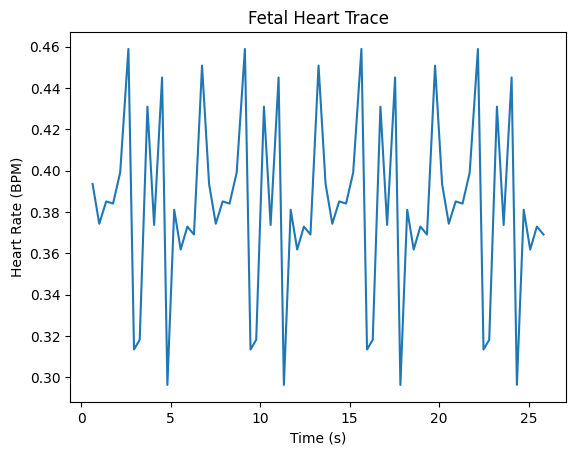

In [26]:
plt.plot(r_peak_times[1:], intervals)
plt.xlabel('Time (s)')
plt.ylabel('Heart Rate (BPM)')
plt.title('Fetal Heart Trace')
plt.show()

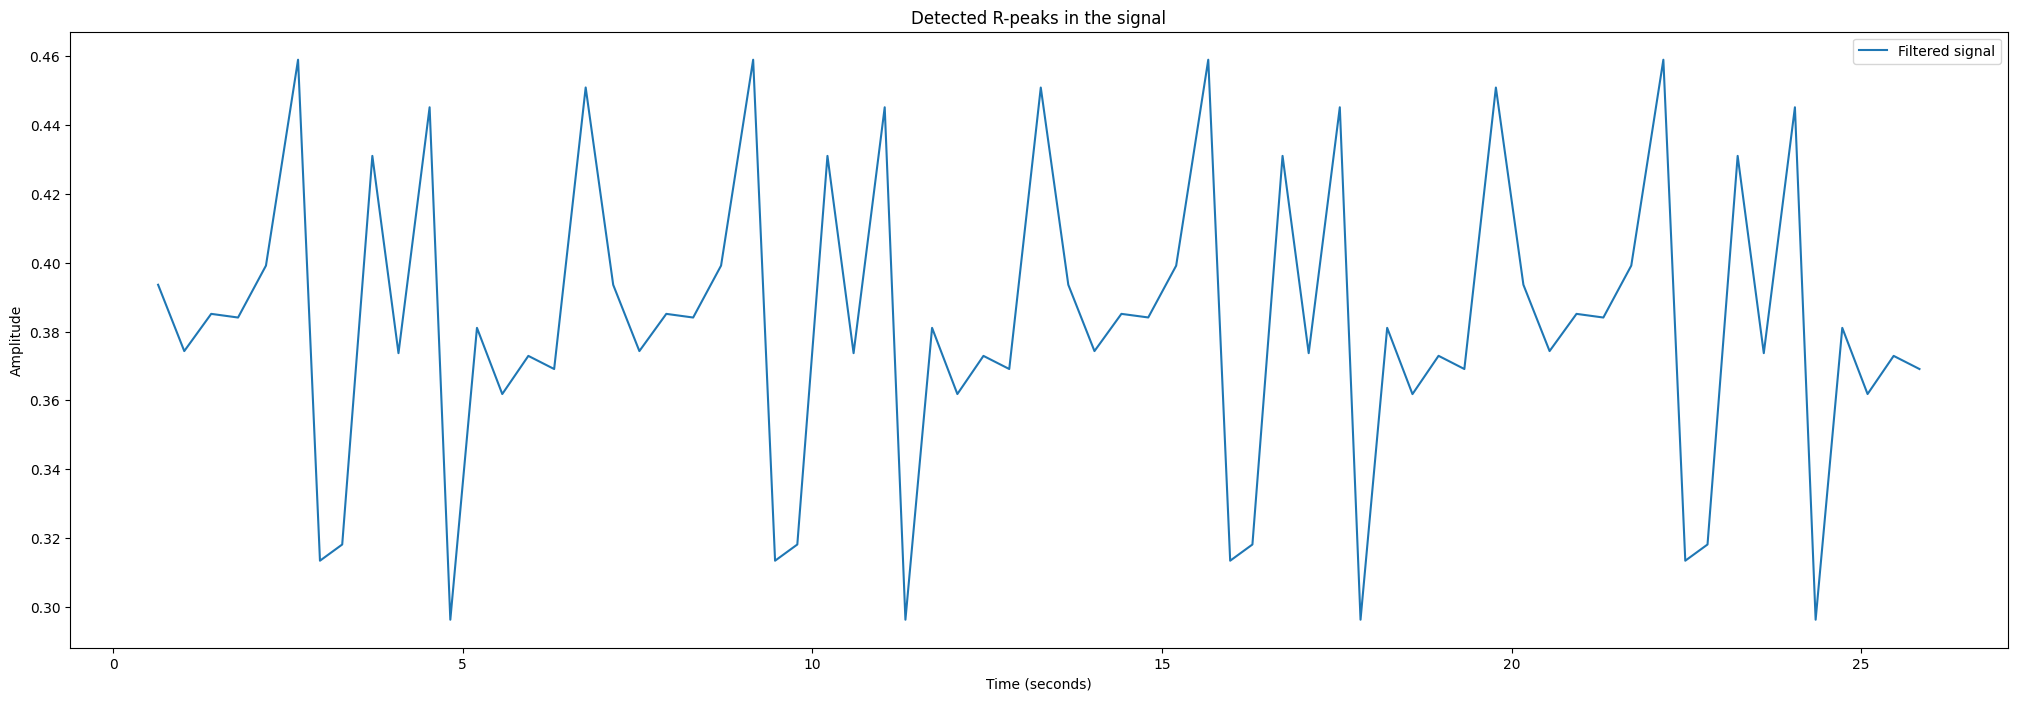

In [34]:

plt.figure(figsize=(25, 8))
plt.plot(r_peak_times[1:], intervals, label='Filtered signal')
plt.title('Detected R-peaks in the signal')
plt.legend()
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.fft import fft
from scipy.signal.windows import tukey 
from scipy.signal import detrend

In [36]:
D_times = r_peak_times

In [37]:
RR_intervals = np.diff(D_times)
times  = D_times[1:(len(D_times))]

In [38]:
mean_rr = np.mean(RR_intervals)
std_rr = np.std(RR_intervals)
nn_intervals = RR_intervals[(RR_intervals > mean_rr - 3 * std_rr) & (RR_intervals < mean_rr + 3 * std_rr)]

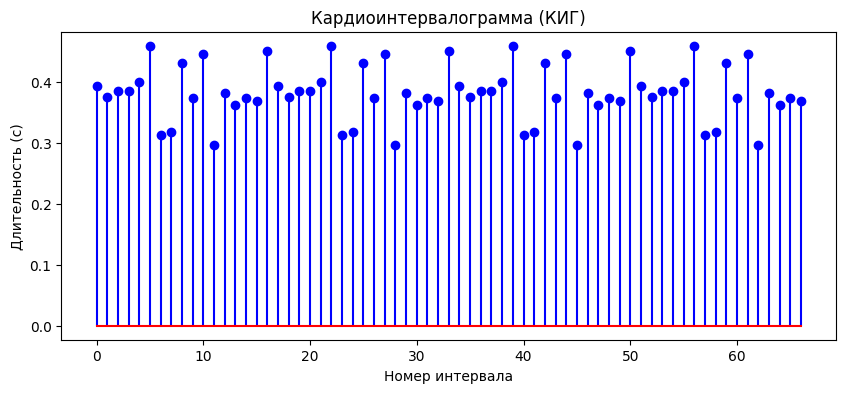

In [39]:
plt.figure(figsize=(10, 4))
plt.stem(nn_intervals, linefmt='b-', markerfmt='bo', basefmt="r-")
plt.title("Кардиоинтервалограмма (КИГ)")
plt.xlabel("Номер интервала")
plt.ylabel("Длительность (с)")
plt.show()

In [40]:
# Интерполяция для равномерной дискретизации сигнала КИГ
times = D_times[1:]  # Пропускаем первое значение, т.к. diff уменьшает длину на 1
valid_indices = (RR_intervals > mean_rr - 3 * std_rr) & (RR_intervals < mean_rr + 3 * std_rr)
interp_func = interp1d(times[valid_indices], nn_intervals, kind='linear', fill_value="extrapolate")

In [41]:
# Равномерная сетка времени для дискретизации
fInt = 4  # Частота дискретизации, Гц
interp_times = np.arange(times[0], times[-1], 1 / fInt)
interp_intervals = interp_func(interp_times)

In [96]:
interp_intervals[1]

0.37451905905861604

In [98]:
interp_intervals

array([0.39358333, 0.37451906, 0.3851142 , 0.38411954, 0.39854247,
       0.44680512, 0.32502683, 0.32822042, 0.42818991, 0.37414489,
       0.43450231, 0.30051559, 0.38001643, 0.3630079 , 0.37241805,
       0.38014025, 0.44937445, 0.3965168 , 0.37497707, 0.3846652 ,
       0.38411443, 0.39777612, 0.44416223, 0.33444412, 0.32290863,
       0.42287812, 0.37725501, 0.4312478 , 0.29687548, 0.38092989,
       0.36240517, 0.37262752, 0.37646002, 0.44567978, 0.39948732,
       0.37602185, 0.38409584, 0.3841893 , 0.39699473, 0.44151326,
       0.34386142, 0.31809516, 0.41756634, 0.38036514, 0.4279933 ,
       0.30706594, 0.37641738, 0.36186668, 0.37285739, 0.37278209,
       0.44200185, 0.40243932, 0.37706591, 0.38352648, 0.38422663,
       0.39624343, 0.43887644, 0.35327871, 0.31779501, 0.41225455,
       0.38347526, 0.4247388 , 0.3172564 , 0.37190488, 0.36296629,
       0.37254321, 0.36910417])

In [97]:
variable_component

array([ 8.25568474e-03, -1.07082196e-02, -1.27040157e-05, -9.06997535e-04,
        1.36163042e-02,  6.19793227e-02, -5.96986037e-02, -5.64046399e-02,
        4.36652197e-02, -1.02794286e-02,  5.01783586e-02, -8.37079866e-02,
       -4.10677547e-03, -2.10149398e-02, -1.15044220e-02, -3.68184925e-03,
        6.56527177e-02,  1.28954382e-02, -8.54392500e-03,  1.24457536e-03,
        7.94176514e-04,  1.45562433e-02,  6.10427176e-02, -4.85750205e-02,
       -6.00101378e-02,  4.00597218e-02, -5.46301800e-03,  4.86301424e-02,
       -8.56418132e-02, -1.48703105e-03, -1.99113771e-02, -9.58866391e-03,
       -5.65579006e-03,  6.36643403e-02,  1.75722518e-02, -5.79285375e-03,
        2.38150560e-03,  2.57533371e-03,  1.54811385e-02,  6.01000383e-02,
       -3.74514373e-02, -6.31173266e-02,  3.64542239e-02, -6.46607414e-04,
        4.70819262e-02, -7.37450649e-02, -4.29324985e-03, -1.87435854e-02,
       -7.65250787e-03, -7.62742966e-03,  6.16927007e-02,  2.22305353e-02,
       -3.04250172e-03,  

In [61]:
# ** Удаление тренда для выделения переменной составляющей
variable_component = detrend(interp_intervals)

In [62]:
max_variability_amplitude = np.max(variable_component) - np.min(variable_component)
print("Максимальная амплитуда вариабельности:", max_variability_amplitude)

Максимальная амплитуда вариабельности: 0.15129453084653383


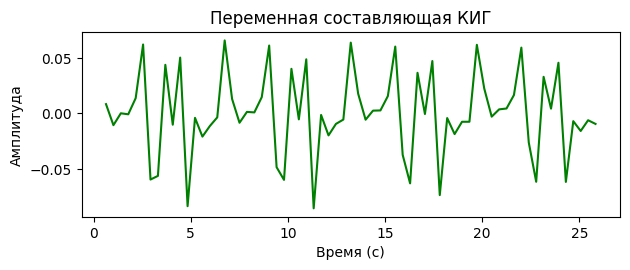

In [63]:
# График переменной составляющей КИГ
plt.subplot(2, 1, 2)
plt.plot(interp_times, variable_component, label="Переменная составляющая КИГ", color="green")
plt.title("Переменная составляющая КИГ")
plt.xlabel("Время (с)")
plt.ylabel("Амплитуда")

plt.tight_layout()
plt.show()

In [65]:
interp_times.shape, variable_component.shape

((67,), (67,))

In [89]:
np.average(abs(60/variable_component/1000))

80.3681259927672

In [92]:
variable_component[2]

-1.2704015676157088e-05

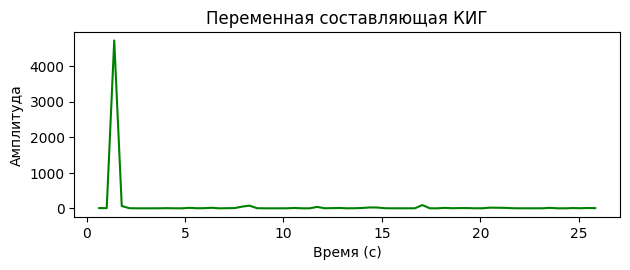

In [78]:
# График переменной составляющей ЧСС
plt.subplot(2, 1, 2)
plt.plot(interp_times, abs(60/variable_component/1000), label="Переменная составляющая КИГ", color="green")
plt.title("Переменная составляющая КИГ")
plt.xlabel("Время (с)")
plt.ylabel("Амплитуда")

plt.tight_layout()
plt.show()

In [45]:
# 5. Интерполяция для восстановления удалённых интервалов
# Используем линейную интерполяцию
times = D_times[1:]  # Пропускаем первое значение, т.к. diff уменьшает длину на 1
valid_indices = (RR_intervals > mean_rr - 3 * std_rr) & (RR_intervals < mean_rr + 3 * std_rr)
interp_func = interp1d(times[valid_indices], nn_intervals, kind='linear', fill_value="extrapolate")
interp_times = np.linspace(times[0], times[-1], num=len(times))
interp_intervals = interp_func(interp_times)

In [46]:
# 6. Кубическая сплайн-интерполяция
fInt = 4  # Частота дискретизации, Гц
x_spline = np.arange(interp_times[0], interp_times[-1], 1 / fInt)
spline_func = interp1d(interp_times, interp_intervals, kind='cubic')
spline_intervals = spline_func(x_spline)

In [47]:
# 7. Удаление линейного тренда
detrended_intervals = spline_intervals - np.mean(spline_intervals)

In [48]:
# 8. Применение окна Тьюки и расчёт БПФ
window = tukey(len(detrended_intervals), alpha=0.25)
windowed_signal = detrended_intervals * window
n_fft = 2048
fft_result = fft(windowed_signal, n=n_fft)
frequencies = np.fft.fftfreq(n_fft, d=1 / fInt)

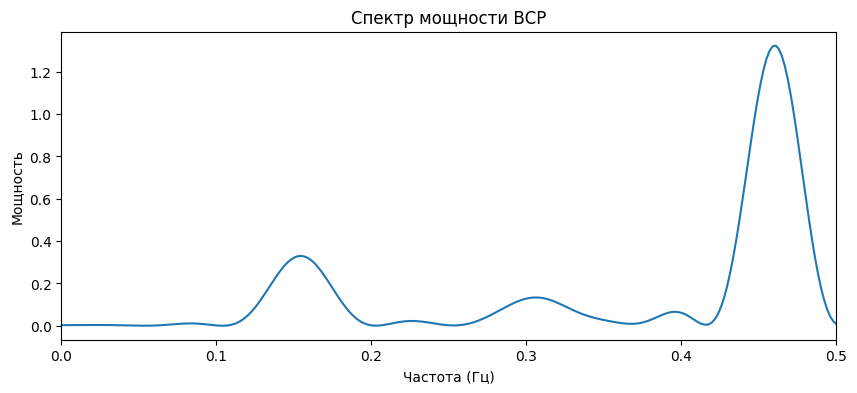

In [49]:
# 9. Построение спектра мощности
plt.figure(figsize=(10, 4))
plt.plot(frequencies[:n_fft // 2], np.abs(fft_result[:n_fft // 2])**2)
plt.title("Спектр мощности ВСР")
plt.xlabel("Частота (Гц)")
plt.ylabel("Мощность")
plt.xlim(0, 0.5)
plt.show()

In [50]:
# 10. Вычисление мощностей VLF, LF, HF
VLF_band = (0.003, 0.04)
LF_band = (0.04, 0.15)
HF_band = (0.15, 0.4)

def band_power(frequencies, power_spectrum, band):
    idx_band = np.where((frequencies >= band[0]) & (frequencies <= band[1]))
    return np.trapz(np.abs(power_spectrum[idx_band])**2, frequencies[idx_band])

In [51]:
# Мощности компонентов
power_spectrum = np.abs(fft_result[:n_fft // 2])**2
VLF_power = band_power(frequencies[:n_fft // 2], power_spectrum, VLF_band)
LF_power = band_power(frequencies[:n_fft // 2], power_spectrum, LF_band)
HF_power = band_power(frequencies[:n_fft // 2], power_spectrum, HF_band)

In [52]:
print(f"VLF Power: {VLF_power}")
print(f"LF Power: {LF_power}")
print(f"HF Power: {HF_power}")

VLF Power: 3.437757398613193e-07
LF Power: 0.0011528606618760988
HF Power: 0.0029560541188063437


Text(0, 0.5, 'RR-интервал (с)')

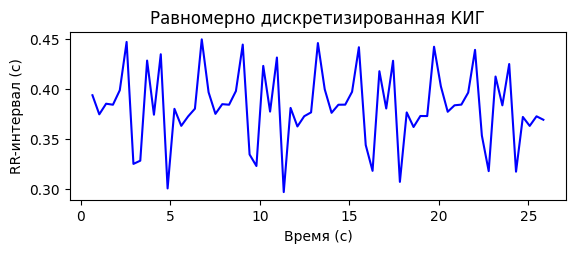

In [72]:
# График исходной КИГ
plt.subplot(2, 1, 1)
plt.plot(interp_times, interp_intervals, label="Равномерно дискретизированная КИГ", color="blue")
plt.title("Равномерно дискретизированная КИГ")
plt.xlabel("Время (с)")
plt.ylabel("RR-интервал (с)")

In [ ]:
plt.subplot(2, 1, 2)
plt.plot(interp_times, variable_component, label="Переменная составляющая КИГ", color="green")
plt.title("Переменная составляющая КИГ")
plt.xlabel("Время (с)")
plt.ylabel("Амплитуда")